This notebook
 * checks the mask,
 * displays the simulation maps, both ILC and noise,
 * derives the transfer-function,
 * calculates the central noise level
 * calculates tniti

In [334]:
import numpy as np
import healpy as hp
import warnings
warnings.filterwarnings('ignore')

from scipy.signal import savgol_filter as sf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from MSC import pospace as ps

from lerepi.config.cmbs4.data import data_08d as sims_if
sims  = sims_if.ILC_May2022('00')

simids = np.array([0])
nside = 2048
lmax = 2047
lmax_plot = lmax

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

cmbs4_edges = np.array([30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1200, 1400, 1600, 1800, 2000])
cmbs4_edges = np.arange(0,4000,100)
edges_center = (cmbs4_edges[1:]+cmbs4_edges[:-1])/2
lmax_cl = 2048
lmax_lib = 3*lmax_cl-1

In [2]:
def bandpass_alms(alms, lmin, lmax=None):
    """
    lmin: minimum multipole to keep in alms
    lmax: maximimum multipole to keep in alms
    """
    
    if len(alms) == 3:
        out = np.zeros(alms.shape, dtype=complex)
        for idx, _alms in enumerate(alms):
            out[idx] = bandpass_alms(_alms, lmin, lmax=lmax)
        return out
    
    lmax_in_alms = hp.Alm.getlmax(len(alms))
    if lmax is None:
        lmax = lmax_in_alms
    else:
        assert isinstance(lmax, int), "lmax should be int: {}".format(lmax)
        assert lmax <= lmax_in_alms, "lmax exceeds lmax in alms: {} > {}".format(lmax, lmax_in_alms)
    
    fl = np.zeros(lmax_in_alms + 1, dtype=float)
    fl[lmin:lmax+1] = 1
    
    return hp.almxfl(alms, fl)

In [ ]:
beam = 2.3
lmax_transf = 2048
tf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf) * hp.pixwin(2048, lmax=lmax_transf)

# 08d

In [259]:
from lerepi.config.cmbs4.data import data_08d as d08d

sims = d08d.ILC_May2022('00')
NQU = sims.get_noise_sim_pmap(0)

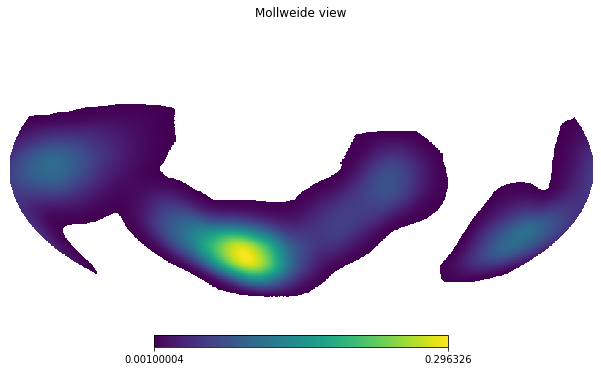

In [260]:
fg = '00'
mask_full = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08d.%s_umilta_220502'%fg+'/ILC_mask_08d_smooth_30arcmin.fits') # 
hp.mollview(np.where(mask_full>0.001,mask_full, np.inf))

## Check masks

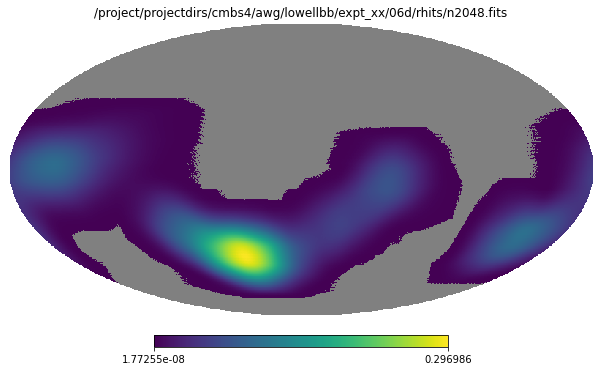

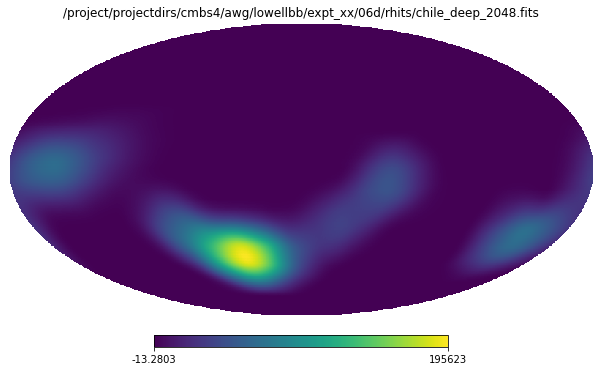

In [285]:
mask_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
mask_chiledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')
hp.mollview(mask_n2048, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
hp.mollview(mask_chiledeep, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')

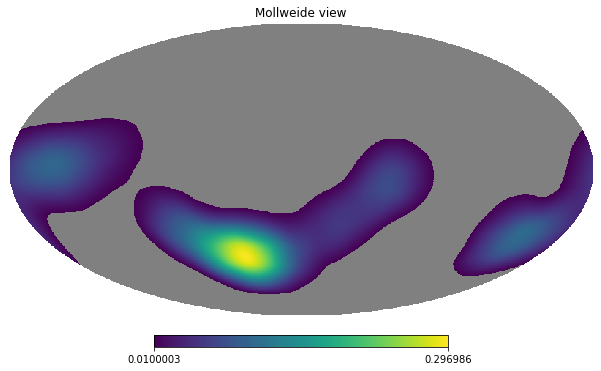

In [515]:
mask = np.where(mask_n2048<0.01,np.nan,mask_n2048) *(~np.isnan(mask_n2048))
hp.mollview(mask)

## Choose mask

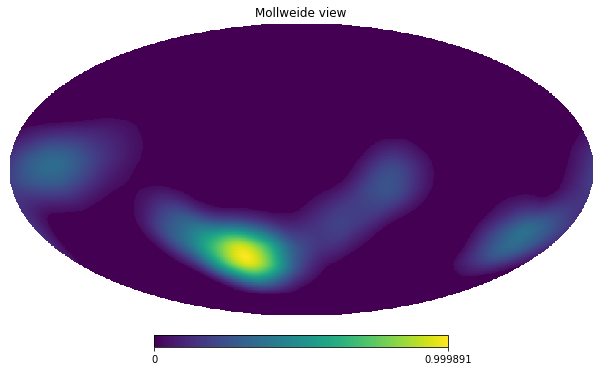

In [516]:
treshold_noisetemplate = 100
mask = np.nan_to_num(mask)
mask_noisetemplate = np.where(mask/np.max(mask)<1/treshold_noisetemplate,0,mask/np.max(mask))
hp.mollview(mask_noisetemplate)

## Build noise template

In [517]:
clN_templ = 3e-7*np.ones(shape=6144)

## Choose mask for central value

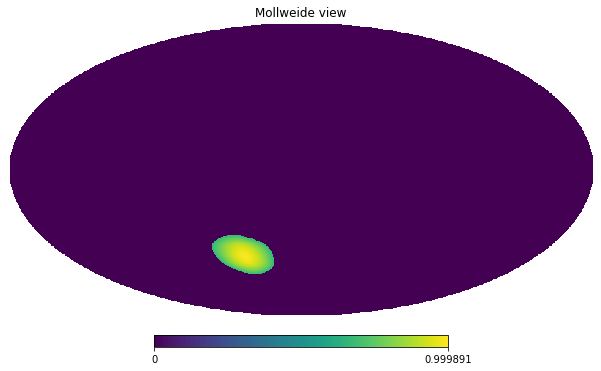

In [518]:
treshold = 1.5
mask_noisetemplate = np.nan_to_num(mask_noisetemplate)
mask_center = np.where(mask_noisetemplate<1/treshold,0,mask_noisetemplate)
hp.mollview(mask_center)

## Calculate

In [519]:
ClN_binned = ps.map2cl_spin_binned(mask_center, 2, clN_templ*1.01, clN_templ, cmbs4_edges, 6144)
ClN_binned_cs = ClN_binned.map2cl(NQU)

Calculating coupling matrix...
zero ww at 31.6 deg
 [00:00:06]  ---------> 97%
 [00:00:06]  ---------> 97%


0.7090379921070014 0.6783363224986877


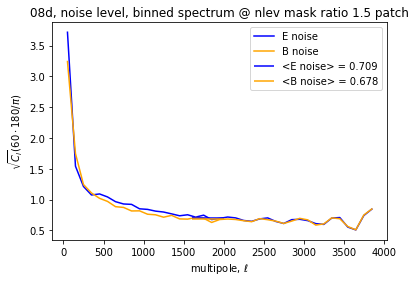

In [522]:
ct = clN_templ[np.array(edges_center,dtype=int)]
nlev_e = np.sqrt(ClN_binned_cs[0]*ct) * (60 * 180 / np.pi)
nlev_b = np.sqrt(ClN_binned_cs[1]*ct) * (60 * 180 / np.pi)

plt.plot(edges_center, nlev_e, label='E noise', color='blue')
plt.plot(edges_center, nlev_b, label='B noise', color='orange')
plt.hlines(np.mean(nlev_e[16:20]), 1600, 2000, color='blue', label='<E noise> = %.3f'%(np.mean(nlev_e[16:20])))
plt.hlines(np.mean(nlev_b[16:20]), 1600, 2000, color='orange', label='<B noise> = %.3f'%(np.mean(nlev_b[16:20])))
# plt.fill_between([1600,1700,1800,1900,2000], 0.3*np.ones(shape=5), np.mean(nlev[16:20])*np.ones(shape=5), alpha=0.5, color='black')
plt.legend()
plt.title('08d, noise level, binned spectrum @ nlev mask ratio {} patch'.format(treshold))
plt.xlabel('multipole, $\ell$')
plt.ylabel('$\sqrt{C_l} (60 \cdot 180 / \pi)$')
print(np.mean(nlev_e[16:20]), np.mean(nlev_b[16:20]))

# 08b

In [523]:
from lerepi.config.cmbs4.data import data_08b as sims_interface

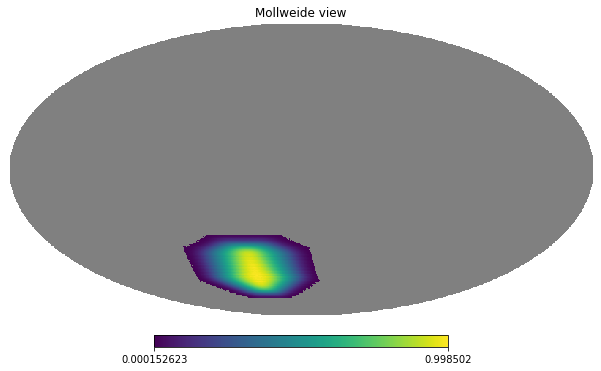

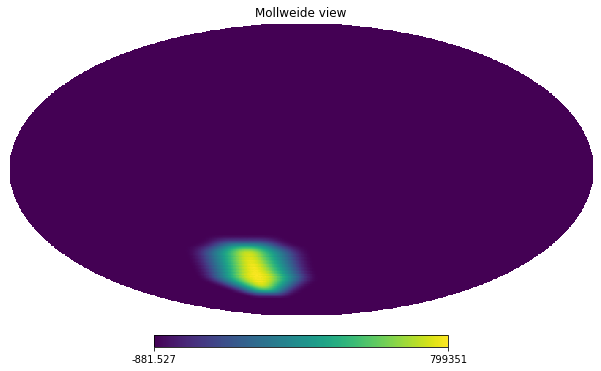

In [524]:
mask_poledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/pole_deep_2048.fits')
mask_pole_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/n2048.fits')
hp.mollview(mask_pole_n2048)
hp.mollview(mask_poledeep)

In [525]:
sims_may  = sims_interface.caterinaILC_May12('00')
N_08b = sims_may.get_noise_sim_pmap(0)

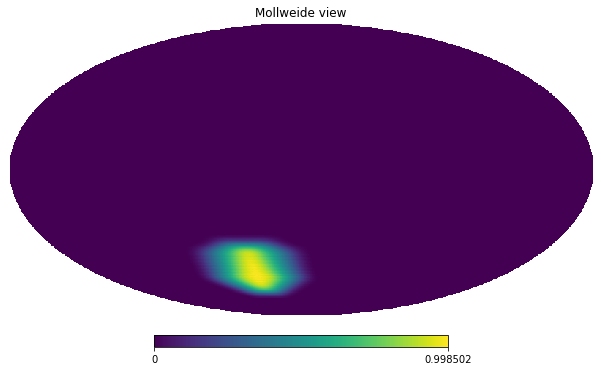

In [526]:
mask_pole_n2048 = np.nan_to_num(mask_pole_n2048)
treshold_noisetemplate = np.inf
mask_noisetemplate = np.where(mask_pole_n2048/np.max(mask_pole_n2048)<1/treshold_noisetemplate,0,mask_pole_n2048)
hp.mollview(mask_noisetemplate)

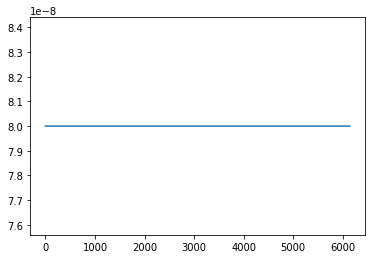

In [527]:
# clN_templ = ps.map2cl(N_08b[0], np.nan_to_num(mask_noisetemplate), 2048, 4096)
clN_templ = 8e-8*np.ones(shape=6144)#*tf[:2048]**2
plt.plot(clN_templ)

In [528]:
# clN_templ = sf(clN_templ, 5, 2)/tf**2
# clN_templ[clN_templ<0] = 0
# plt.plot(clN_templ)
# plt.yscale('log')

In [529]:
# tresholds = [1.5,2,3]

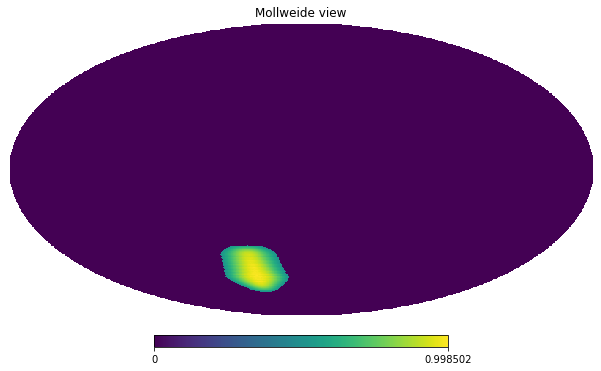

In [530]:
treshold_08b = 2
small_mask_08b = np.where(mask_noisetemplate/np.max(mask_noisetemplate)<1/treshold_08b,0,mask_noisetemplate)
hp.mollview(small_mask_08b)

In [531]:
bin_lib = ps.map2cl_spin_binned(small_mask_08b, 2, clN_templ*1.01, clN_templ, cmbs4_edges, 6144)
CN_08b_binned = bin_lib.map2cl(N_08b)

Calculating coupling matrix...
zero ww at 32.6 deg
 [00:00:06]  ---------> 97%
 [00:00:07]  ---------> 97%


In [532]:
binning = [int(e) for e in edges_center]
nlev_e = np.sqrt(CN_08b_binned[0][1:]*clN_templ[binning][1:]) * (60 * 180 / np.pi)
nlev_b = np.sqrt(CN_08b_binned[1][1:]*clN_templ[binning][1:]) * (60 * 180 / np.pi)

0.39586127394816156 0.3814755684057164


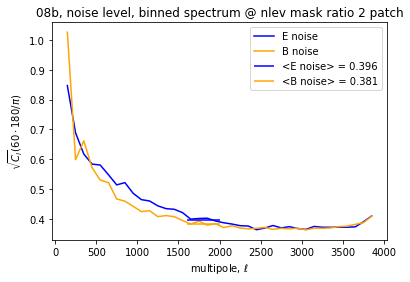

In [533]:
plt.plot(edges_center[1:], nlev_e, label='E noise', color='blue')
plt.plot(edges_center[1:], nlev_b, label='B noise', color='orange')
plt.hlines(np.mean(nlev_e[16:20]), 1600, 2000, color='blue', label='<E noise> = %.3f'%(np.mean(nlev_e[16:20])))
plt.hlines(np.mean(nlev_b[16:20]), 1600, 2000, color='orange', label='<B noise> = %.3f'%(np.mean(nlev_b[16:20])))
# plt.fill_between([1600,1700,1800,1900,2000], 0.3*np.ones(shape=5), np.mean(nlev[16:20])*np.ones(shape=5), alpha=0.5, color='black')
plt.legend()
plt.title('08b, noise level, binned spectrum @ nlev mask ratio {} patch'.format(treshold_08b))
plt.xlabel('multipole, $\ell$')
plt.ylabel('$\sqrt{C_l} (60 \cdot 180 / \pi)$')
print(np.mean(nlev_e[16:20]), np.mean(nlev_b[16:20]))

# Other

In [281]:
np.sqrt(5e-8 * (60 * 180 / np.pi)) / (np.sqrt(hp.nside2pixarea(2048, degrees=True)))

0.45794672179195695

In [25]:
np.sqrt(2e-7 * (60 * 180 / np.pi)) / (np.sqrt(hp.nside2pixarea(2048, degrees=True)))

0.9158934435839139

In [26]:
0.59

0.59

In [28]:
(2e-7)/(5e-8)

4.0

In [371]:
treshold_08b = 1.5
small_mask_08b1 = np.where(mask_noisetemplate/np.max(mask_noisetemplate)<1/treshold_08b,0,mask_noisetemplate)
treshold_08b = 10
small_mask_08b2 = np.where(mask_noisetemplate/np.max(mask_noisetemplate)<1/treshold_08b,0,mask_noisetemplate)

np.sum(np.where(np.nan_to_num(small_mask_08b1)>0,1,0))/np.sum(np.where(np.nan_to_num(small_mask_08b2)>0,1,0))

0.3309626925523383